You can use this template for problems 1, 2 and 3

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
# Students will submit their files with their team-name.py
# Student have to use the Team as their parent class

Recent Version of the Code

In [14]:
class ROLLNUMBER_Q2:
  def __init__(self):
    self.num_arms = 6
    self.wicket = np.zeros(self.num_arms)
    self.occur = np.zeros(self.num_arms)
    self.prev_action = 0
    self.round = 0
    self.a = np.ones(self.num_arms)
    self.b = np.ones(self.num_arms)
    self.runs = np.zeros(self.num_arms)
    self.hmap = np.zeros(6)
    
  @staticmethod
  def kl_div(p, q):
    if q==0 and p==0:
        return 0
    if q==0 and p!=0:
        return pow(10, 10)
    if q==1 and p==1:
        return 0
    if q==1 and p!=1:
        return pow(10, 10)
    if p==0:
        return np.log(1/(1-q))
    if p==1:
        return np.log(1/q)
    
    return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))


  def kl_conf(self, t, em, num_pulls, precision=1e-6, max_iter=50):
    n = 0
    lower_bound = em
    upper_bound = 1
    
    while n<max_iter and (upper_bound - lower_bound)>precision:
        q = (lower_bound + upper_bound)/2
        
        if self.kl_div(em, q) < np.log(1+t*np.log(t)**2)/num_pulls:
            upper_bound = q
        else:
            lower_bound = q
            
        n += 1
    
    return (upper_bound + lower_bound)/2
    
  def get_action(self,wicket,runs_scored):
    X = wicket
    R = runs_scored
    
    if self.round > 0:
        self.occur[self.prev_action] += 1
    
    if self.round < 6:
        action = self.round
    else:
        kl_ucb = np.array([self.kl_conf(self.round, self.runs[idx]/self.occur[idx], self.occur[idx]) for idx in range(self.num_arms)])
        action = np.argmax(kl_ucb)
    
    self.prev_action = action
    self.round += 1
    
    return action


In [15]:
class ROLL_NUMBER_Q2_T:
    def __init__(self):
        self.num_arms = 6
        self.a = np.ones(self.num_arms)
        self.b = np.ones(self.num_arms)
        self.hmap = np.array([0, 1, 2, 3, 4, 6])
        self.prev_action = 0
        self.round = 0
        
    def get_action(self, wicket, runs_scored):
        X = wicket
        R = runs_scored
        
        if self.round > 0:
            if X==1:
                self.b[self.prev_action] += 1
            else:
                if (R==self.prev_action) or (R==6 and self.prev_action==5):
                    self.a[self.prev_action] += 1
                else:
                    self.b[self.prev_action] += 1
        if self.round < 6:
            action = self.round
        else:
            thompson = np.random.beta(self.a, self.b)*self.hmap
            action = np.argmax(thompson)
        
        self.prev_action = action
        self.round += 1
        
        return action

In [16]:
class ROLL_NUMBER_Q2_T_V2:
    def __init__(self):
        self.num_arms = 6
        self.a = np.ones(self.num_arms)
        self.b = np.ones(self.num_arms)
        self.hmap = np.array([0, 1, 2, 3, 4, 6])
        self.prev_action = 0
        self.round = 0
        
    def get_action(self, wicket, runs_scored):
        X = wicket
        R = runs_scored
        
        if self.round > 0:
            if X==1:
                self.b[self.prev_action] += 1
            else:
                if (R==self.prev_action) or (R==6 and self.prev_action==5):
                    self.a[self.prev_action] += 1
                else:
                    self.b[self.prev_action] += 1
        if self.round < 6:
            action = self.round
        else:
            thompson = np.random.beta(self.a, self.b)*self.hmap
            action = np.argmax(thompson)
        
        self.prev_action = action
        self.round += 1
        
        return action

In [17]:
class Environment:
  def __init__(self,num_balls,agent):
    self.num_balls = num_balls
    self.agent = agent
    self.__run_time = 0
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__runs_scored = 0
    self.__start_time = 0
    self.__end_time = 0
    self.__regret_w = 0
    self.__regret_s = 0
    self.__wicket = 0
    self.__regret_rho = 0
    self.__p_out = np.array([0.001,0.01,0.02,0.03,0.1,0.3])
    self.__p_run = np.array([1,0.9,0.85,0.8,0.75,0.7])
    self.__action_runs_map = np.array([0,1,2,3,4,6])
    self.__s = (1-self.__p_out)*self.__p_run*self.__action_runs_map
    self.__rho = self.__s/self.__p_out
    self.regret_s_hist = []

  def __get_action(self):
    self.__start_time      = time. time()
    action          = self.agent.get_action(self.__wicket,self.__runs_scored)
    self.__end_time        = time. time()
    self.__run_time   = self.__run_time + self.__end_time - self.__start_time
    return action


  def __get_outcome(self, action):
    pout = self.__p_out[action]
    prun= self.__p_run[action]
    wicket = np.random.choice(2,1,p=[1-pout,pout])[0]
    runs = 0
    if(wicket==0):
      runs = self.__action_runs_map[action]*np.random.choice(2,1,p=[1-prun,prun])[0]
    return wicket, runs


  def innings(self):
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__runs_scored = 0

    for ball in range(self.num_balls):
      action = self.__get_action()
      self.__wicket, self.__runs_scored   = self.__get_outcome(action)
      self.__total_runs     = self.__total_runs + self.__runs_scored
      self.__total_wickets  = self.__total_wickets + self.__wicket
      self.__regret_w       = self.__regret_w+ (self.__p_out[action]-np.min(self.__p_out))
      self.__regret_s       = self.__regret_s+ (np.max(self.__s) - self.__s[action])
      self.__regret_rho       = self.__regret_rho+ (np.max(self.__rho)-self.__rho[action])
      self.regret_s_hist += [self.__regret_s]
    return self.__regret_w,self.__regret_s,self.__regret_rho, self.__total_runs, self.__total_wickets, self.regret_s_hist, self.__run_time


In [18]:
agent = ROLL_NUMBER_Q2_T()
agent2 = ROLLNUMBER_Q2()
environment = Environment(10000, agent)
environment2 = Environment(10000, agent2)
regret_w,regret_s,reger_rho,total_runs,total_wickets, regret_s_hist, run_time = environment.innings()
regret_w2,regret_s2,reger_rho2,total_runs2,total_wickets2, regret_s_hist2, run_time2 = environment2.innings()

In [19]:
print(regret_w,regret_s,reger_rho,total_runs,total_wickets,run_time)

2955.340999999809 51.70699999999997 789193.2000001009 29491 2950 0.4141988754272461


In [20]:
print(regret_w2,regret_s2,reger_rho2,total_runs2,total_wickets2,run_time2)

0.45499999999999996 29389.474999995135 890713.1999998479 14 5 6.265085697174072


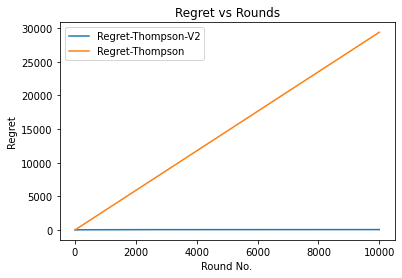

In [21]:
plt.plot(range(10000), regret_s_hist, label='Regret-Thompson-V2')
plt.plot(range(10000), regret_s_hist2, label='Regret-Thompson')
plt.legend()
plt.xlabel('Round No.')
plt.ylabel('Regret')
plt.title('Regret vs Rounds')
plt.show()